In [1]:
#Choose the ATLAS ML kernel from the dropdown menu!
import numpy as np
import h5py
import math
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation, Layer
from tensorflow.keras import backend as K

In [2]:
from func import load_model, save_model, SetStyle
SetStyle()

## Load background dataset

In [3]:
dataset_folder = '/global/cfs/cdirs/ntrain5/atlas-ml-training/anomaly_detection/'
#Be sure to run first if you want to make your own files
# python create_datasets.py --bkg_file background_for_training.h5 --output_bkg_name 'BKG' --signals_files 'Ato4l_lepFilter_13TeV.h5' --output_signal_names 'Ato4l_lepFilter_13TeV' --events=1000000
filename = 'BKG_dataset.h5'

In [4]:
# make sure input data has correct input shape - background training data
with h5py.File(dataset_folder+filename, 'r') as file:
    X_train = np.array(file['X_train'])
    X_test = np.array(file['X_test'])
    X_val = np.array(file['X_val'])

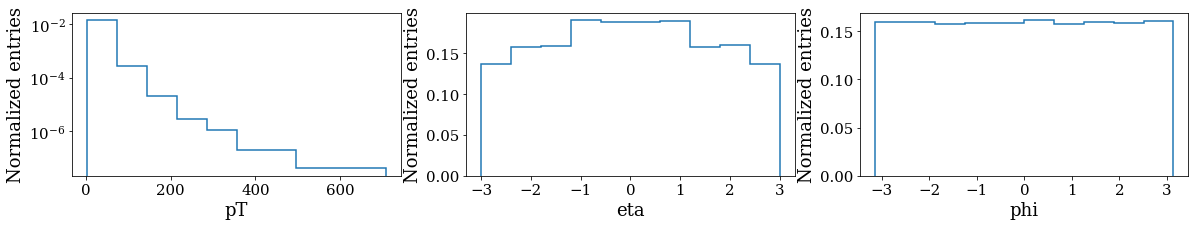

In [5]:
#Let's plot some histograms
plt.figure(figsize=(20,3))
logy_dict = {'pT':True,'eta':False,'phi':False}
for i,name in enumerate(logy_dict):
    plt.subplot(1,3,i+1)
    to_plot=X_train[:,3+i]
    to_plot=to_plot[to_plot!=0]
    plt.hist(to_plot.flatten(),label="Background", density = True, histtype='step', fill=False, linewidth=1.5)
    if logy_dict[name]:plt.yscale('log')
    plt.xlabel(name)
    plt.ylabel("Normalized entries")


## Let's build an autoencoder with fully-connected layers <img src="assets/autoencoder.png" width=400 height=400 />


In [6]:
input_shape = 57
latent_dimension = 8
num_nodes=[32,16]
activation='relu'

In [7]:
#encoder
inputArray = Input(shape=(input_shape))
x = Dense(num_nodes[0], use_bias=False,activation=activation)(inputArray)
x = Dense(num_nodes[1], use_bias=False,activation=activation)(x)
encoder = Dense(latent_dimension, use_bias=False,activation=activation)(x)

#decoder
x = Dense(num_nodes[1], use_bias=False,activation=activation)(encoder)
x = Dense(num_nodes[0], use_bias=False,activation=activation)(x)
decoder = Dense(input_shape)(x)

#create autoencoder
autoencoder = Model(inputs = inputArray, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 57)]              0         
                                                                 
 dense (Dense)               (None, 32)                1824      
                                                                 
 dense_1 (Dense)             (None, 16)                512       
                                                                 
 dense_2 (Dense)             (None, 8)                 128       
                                                                 
 dense_3 (Dense)             (None, 16)                128       
                                                                 
 dense_4 (Dense)             (None, 32)                512       
                                                                 
 dense_5 (Dense)             (None, 57)                1881  

2022-07-29 10:54:53.481542: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-29 10:54:54.092388: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14637 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:1a:00.0, compute capability: 7.0


In [8]:
autoencoder.compile(optimizer = keras.optimizers.Adam(), loss='mse')

## Trainining and saving the model

In [9]:
EPOCHS = 50
BATCH_SIZE = 10000

In [10]:
history = autoencoder.fit(X_train, X_train, epochs = EPOCHS, batch_size = BATCH_SIZE,
                  validation_data=(X_val, X_val))

Epoch 1/50
64/64 [==============================] - 1s 7ms/step - loss: 68.7328 - val_loss: 33.2492
Epoch 2/50
64/64 [==============================] - 0s 3ms/step - loss: 25.4048 - val_loss: 18.0738
Epoch 3/50
64/64 [==============================] - 0s 3ms/step - loss: 11.6945 - val_loss: 6.0082
Epoch 4/50
64/64 [==============================] - 0s 3ms/step - loss: 3.8452 - val_loss: 2.6804
Epoch 5/50
64/64 [==============================] - 0s 3ms/step - loss: 2.4143 - val_loss: 2.2380
Epoch 6/50
64/64 [==============================] - 0s 3ms/step - loss: 2.0867 - val_loss: 1.9622
Epoch 7/50
64/64 [==============================] - 0s 3ms/step - loss: 1.8100 - val_loss: 1.6539
Epoch 8/50
64/64 [==============================] - 0s 3ms/step - loss: 1.3865 - val_loss: 1.0910
Epoch 9/50
64/64 [==============================] - 0s 3ms/step - loss: 0.9259 - val_loss: 0.8421
Epoch 10/50
64/64 [==============================] - 0s 3ms/step - loss: 0.8032 - val_loss: 0.7690
Epoch 11/50
64

In [11]:
model_name = 'DNN_AE'
model_directory = 'DNNS/'
if not os.path.exists(model_directory+model_name):
    os.makedirs(model_directory+model_name)
save_model(model_directory+model_name, autoencoder)

## Let's take a look at the reconstruction for the background

In [12]:
bkg_prediction = autoencoder.predict(X_test,batch_size=1000)

6250/6250 [==============================] - 5s 711us/step


## Now let's take a look at the signals! <img src="assets/NP.png" width=800 height=200 />

In [13]:
# add correct signal labels: defined within the h5 file created by the data processing script
signal_labels = ['A to 4 leptons',
                 'h to tau tau',
                 'leptoquark',
                 'charged h to tau nu']
# add correct path to signal files
signals_file = ['Ato4l_lepFilter_13TeV_dataset.h5',
                'hToTauTau_13TeV_PU20_dataset.h5',
                'leptoquark_LOWMASS_lepFilter_13TeV_dataset.h5',
                'hChToTauNu_13TeV_PU20_dataset.h5']

In [14]:
# read signal data
signal_data = []
for i, label in enumerate(signal_labels):
    with h5py.File(dataset_folder+signals_file[i], 'r') as file:
        test_data = np.array(file['Data'])
    signal_data.append(test_data)

In [15]:
signal_results = []

for i, label in enumerate(signal_labels):
    signal_prediction = autoencoder.predict(signal_data[i],batch_size=1000)
    signal_results.append([label, signal_data[i], signal_prediction]) # save [label, true, prediction] for signal

23759/23759 [==============================] - 17s 703us/step


## Before looking into the results, let's save the trained model in case we want to use it again

In [16]:
save_file = 'dnn_results'

In [17]:
with h5py.File(save_file, 'w') as file:
    file.create_dataset('BKG_input', data=X_test)
    file.create_dataset('BKG_predicted', data = bkg_prediction)
    for i, sig in enumerate(signal_results):
        file.create_dataset('%s_input' %sig[0], data=sig[1])
        file.create_dataset('%s_predicted' %sig[0], data=sig[2])

# Evaluating the autoencoder

## Let's take a look at the reconstruction error for the different signals and background

In [18]:
from func import mse_loss

In [19]:
# compute loss value (true, predicted)
total_loss = []
total_loss.append(mse_loss(X_test, bkg_prediction))
for i, signal_X in enumerate(signal_data):
    total_loss.append(mse_loss(signal_X, signal_results[i][2]))

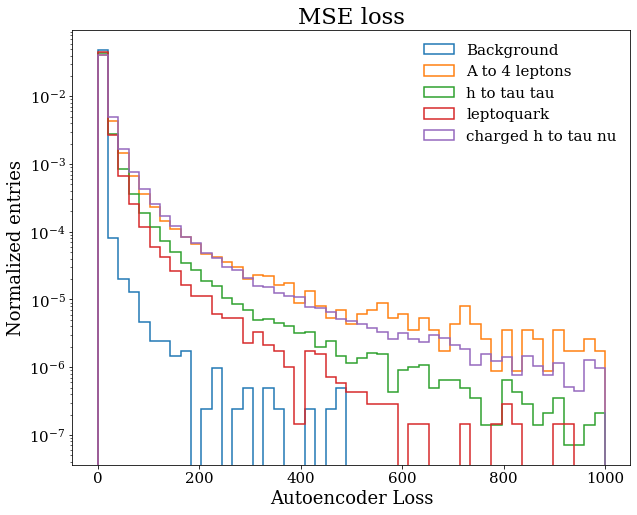

In [20]:
binning=np.linspace(0,1000,50)

plt.figure(figsize=(10,8))
plt.hist(total_loss[0], bins=binning, label="Background", density = True, histtype='step', fill=False, linewidth=1.5)
for i, label in enumerate(signal_labels):
    plt.hist(total_loss[i+1], bins=binning, label=label, density = True, histtype='step', fill=False, linewidth=1.5)
plt.yscale('log')
plt.xlabel("Autoencoder Loss")
plt.ylabel("Normalized entries")
plt.title('MSE loss')
plt.legend(loc='best')
plt.show()

## Let's now make a Receiver Operating Characteristic (ROC) curve

In [21]:
from sklearn.metrics import roc_curve, auc

In [22]:
labels = np.concatenate([['Background'], np.array(signal_labels)])

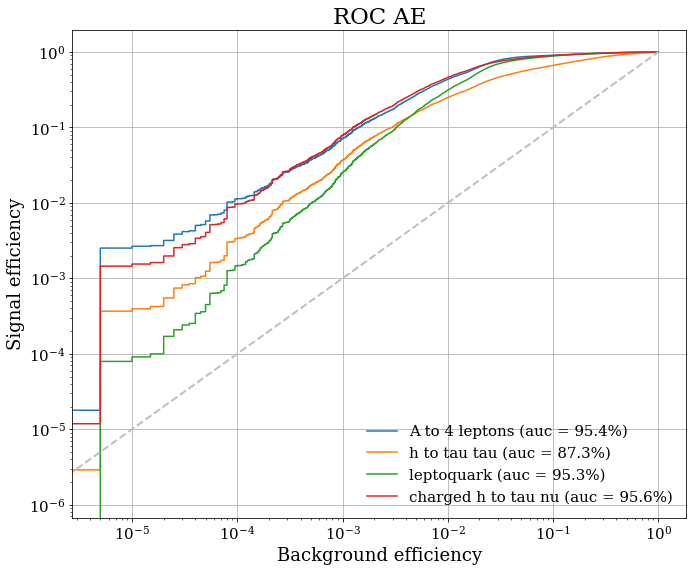

In [23]:
target_background = np.zeros(total_loss[0].shape[0])

plt.figure(figsize=(10,8))
for i, label in enumerate(labels):
    if i == 0: continue # background events
    
    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

    auc_loss = auc(fpr_loss, tpr_loss)
    
    plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)'%(label,auc_loss*100.), linewidth=1.5)
    
    plt.semilogx()
    plt.semilogy()
    plt.ylabel("Signal efficiency")
    plt.xlabel("Background efficiency")
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.title("ROC AE")
plt.show()

## Let's now make a Significance Improvement (SIC) curve

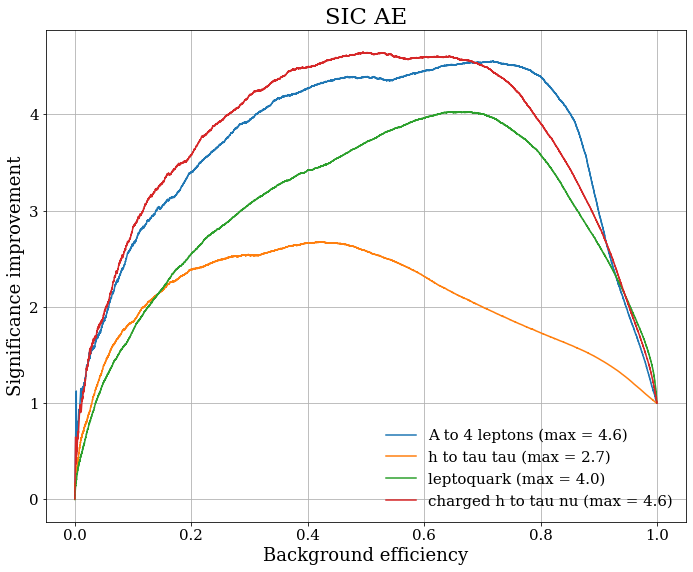

In [25]:
target_background = np.zeros(total_loss[0].shape[0])

plt.figure(figsize=(10,8))
for i, label in enumerate(labels):
    if i == 0: continue # background events
    
    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)    
    plt.plot(tpr_loss,np.ma.divide(tpr_loss,np.sqrt(fpr_loss)), "-", label='%s (max = %.1f)'%(label,np.max(np.ma.divide(tpr_loss,np.sqrt(fpr_loss)))), linewidth=1.5)
    

    plt.ylabel("Significance improvement")
    plt.xlabel("Background efficiency")
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
plt.title("SIC AE")
plt.show()